In [2]:
!pip install --upgrade pip
!pip install imutils

Requirement already up-to-date: pip in /home/nbuser/anaconda3_420/lib/python3.5/site-packages (20.1.1)


# Library

In [3]:
import numpy as np
import pandas as pd
from skimage import io
import os

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as pac

import statistics

from PIL import Image

import imutils.paths as path
from tqdm import tqdm

from skimage import filters, util, exposure, data, segmentation
from skimage.color import rgb2gray
from skimage.util import img_as_float, crop
from skimage.filters import median
from skimage.morphology import disk
from skimage.segmentation import (morphological_chan_vese,
                                  morphological_geodesic_active_contour,
                                  inverse_gaussian_gradient,
                                  checkerboard_level_set, circle_level_set)
from skimage.feature import greycomatrix, greycoprops
from skimage.measure import regionprops, label

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


# Preprocessing

## Read File

In [40]:
PATH = 'nomls_resize'
imagePaths = sorted(list(path.list_images(PATH)))

datanomls = []
datagrayno = []
for i in tqdm(imagePaths[0:2], desc="load"):
    img = mpimg.imread(i)
    imgg = rgb2gray(img)
    imgtofloat = img_as_float(imgg)
    datagrayno.append(imgg)
    datanomls.append(imgtofloat)

load: 100%|██████████| 2/2 [00:05<00:00,  2.96s/it]


In [4]:
PATH2 = 'mls_resize'
imagePaths2 = sorted(list(path.list_images(PATH2)))

datamls = []
datagray =[]
for j in tqdm(imagePaths2[28:30], desc="load"):
    img2 = mpimg.imread(j)
    imgg2 = rgb2gray(img2)
    imgtofloat2 = img_as_float(imgg2)
    datagray.append(imgg2)
    datamls.append(imgtofloat2)

load: 100%|██████████| 2/2 [00:13<00:00,  6.57s/it]


## Median dan Otsu Thresholding

In [41]:
hasil_cb = []
hasil_median = []

for i in tqdm(range(len(datanomls)), desc='preprocessing'):
    med = median(datanomls[i], disk(5))
    val = filters.threshold_otsu(med)
    mask = med < val
    clean_border = segmentation.clear_border(mask)
    hasil_median.append(med)
    hasil_cb.append(clean_border)

preprocessing:   0%|          | 0/2 [00:00<?, ?it/s]/home/nbuser/anaconda3_420/lib/python3.5/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
preprocessing: 100%|██████████| 2/2 [00:03<00:00,  1.64s/it]


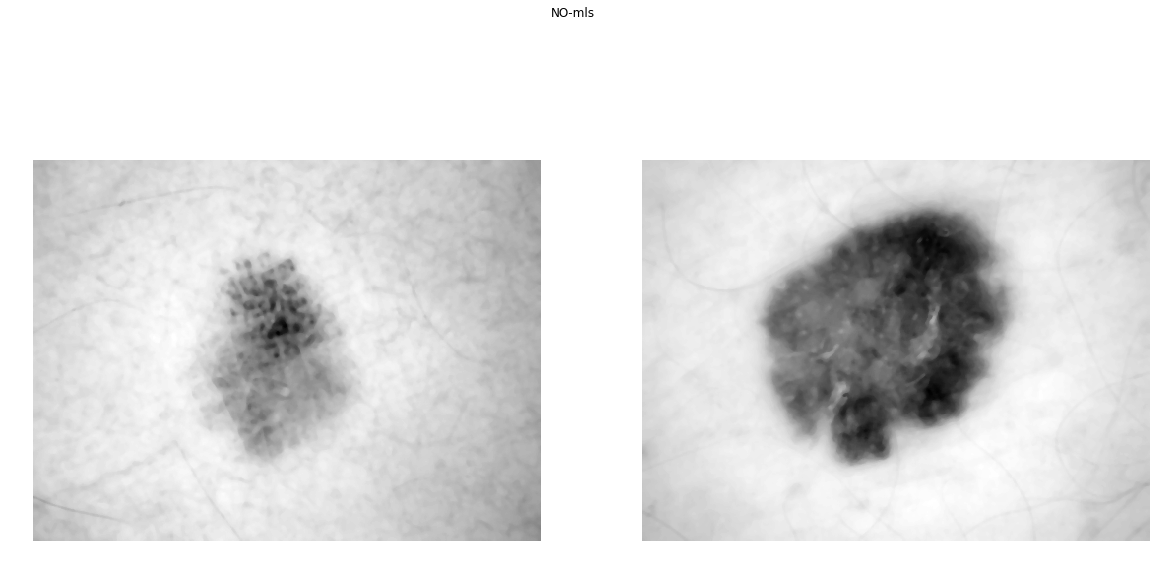

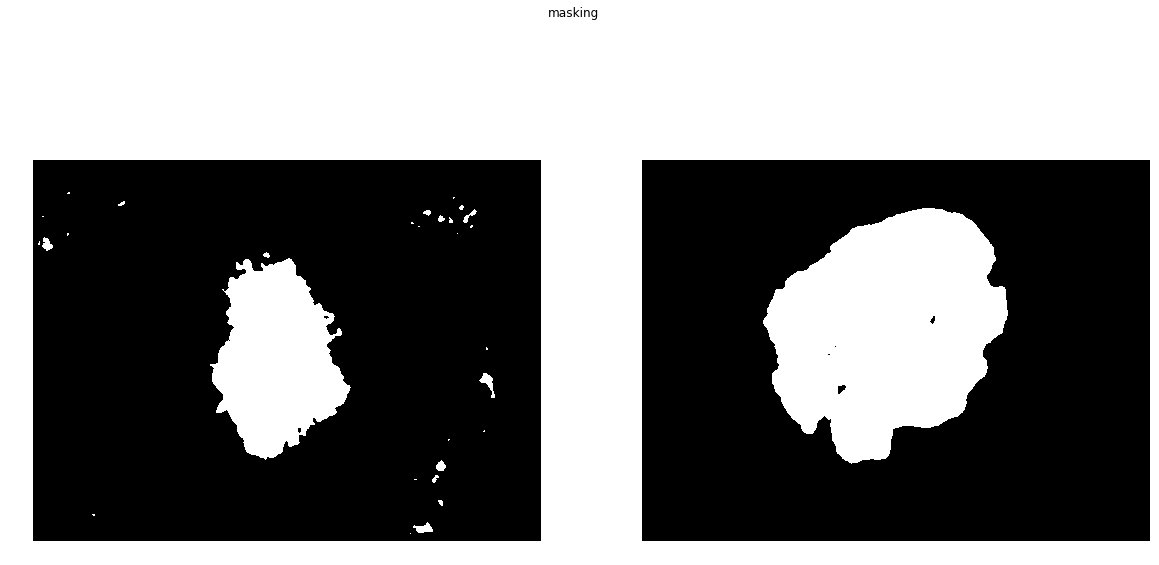

In [42]:
f, gambar1 = plt.subplots(1,2, figsize=(20, 10))
g, gambar2 = plt.subplots(1,2, figsize=(20, 10))

gambar1 = gambar1.ravel()
gambar2 = gambar2.ravel()

f.suptitle('NO-mls')
g.suptitle('masking')

for i, image1 in enumerate(hasil_median[:]):
    gambar1[i].imshow(image1, cmap='gray')
    gambar1[i].axis('off')

for j, image2 in enumerate(hasil_cb[:]):
    gambar2[j].imshow(image2, cmap='gray')
    gambar2[j].axis('off')

## PSNR dan MSE

In [43]:
def PSNR(original, ukuran): 
    compressed = median(original, disk(ukuran))/255
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr, mse

In [45]:
skorpsnr 
skorpsnr, skormse = PSNR(datagrayno[0], 10)
print('PSNR = ', skorpsnr)
print('MSE = ', skormse)

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


PSNR =  86.59184814763793
MSE =  0.00014252647562710885


## Automatic Cropping

crop:   0%|          | 0/2 [00:00<?, ?it/s]/home/nbuser/anaconda3_420/lib/python3.5/site-packages/skimage/measure/_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
crop: 100%|██████████| 2/2 [00:00<00:00,  4.10it/s]


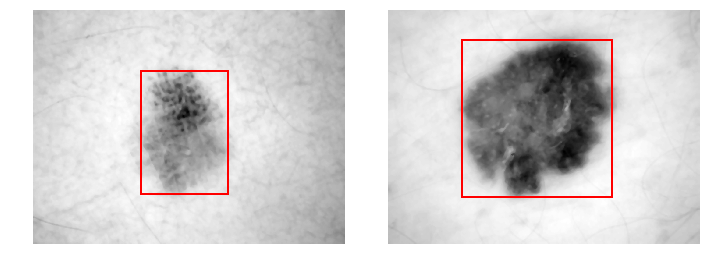

In [73]:
# create array in which to store cropped articles
labeledd = []
cropped_images = []
cropped_images_no = []
cropped_images_pad = []
filled = []

asym_index = []
compactness = []
perimeter = []
diameter = []
x_center = []
y_center = []
area_lesi = []
titiktitik = []

# define amount of padding to add to cropped image
pad = 10

fig1, ax1 = plt.subplots(1,2, figsize=(10, 6))
for i, image1 in enumerate(hasil_median[:]):
    ax1[i].imshow(image1, cmap = 'gray')
    ax1[i].axis('off')
    
for i in tqdm(range(len(hasil_cb)), desc = 'crop'):    
    ukuran = (hasil_cb[i].size)/100
    labeled = label(hasil_cb[i])
    if (np.sum(hasil_cb[i] == 1)) >= ukuran:
# for each segment number, find the area of the given segment.
        for region_index, region in enumerate(regionprops(labeled)):
            if region.area < 5000:
                continue

  # draw a rectangle around the segmented area
            minr, minc, maxr, maxc = region.bbox
            image_filled = region.filled_image
            rectangle = pac.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                        fill=False, edgecolor='red', linewidth=2)
            ax1[i].add_patch(rectangle)
        
            m = region.moments
            area_l = m[0][0]
            peri = region.perimeter
            diam = region.equivalent_diameter
            #xbar = region.centroid[0]
            #ybar = region.centroid[1]
            xbar = m[1][0]/area_l
            ybar = m[0][1]/area_l
            miu11 = m[1][1] - (xbar*m[0][1])
            miu20 = m[2][0] - (xbar*m[1][0])
            miu02 = m[0][2] - (ybar*m[0][1])
            miuaks11 = miu11/area_l
            miuaks20 = miu20/area_l
            miuaks02 = miu02/area_l

            asi = 2*miuaks11/(miuaks20-miuaks02)
            teta = 0.5*np.arctan(asi)
            asym = 0.5*((teta/area_l)+((teta+np.pi/2)/area_l))
            compact_index = peri**2/4*np.pi*area_l
        
  # use those bounding box coordinates to crop the image
            cropped_images_pad.append(hasil_median[i][minr-pad:maxr+pad, minc-pad:maxc+pad])
            cropped_images.append(hasil_median[i][minr:maxr, minc:maxc])
            filled.append(image_filled)
            asym_index.append(asym)
            compactness.append(compact_index)
            perimeter.append(peri)
            x_center.append(xbar)
            y_center.append(ybar)
            area_lesi.append(area_l)
            diameter.append(diam)
            titiktitik.append(region.bbox)
    elif (np.sum(hasil_cb[i]) < ukuran):
        height, width = hasil_cb[i].shape
        
        top = height // 6
        bottom = height // 3
        right = width // 4
        left = width // 7
        
        im1 = crop(hasil_median[i], ((top,bottom), (left, right)), copy=False)        
        cropped_images_no.append(im1)

plt.tight_layout()
plt.show()

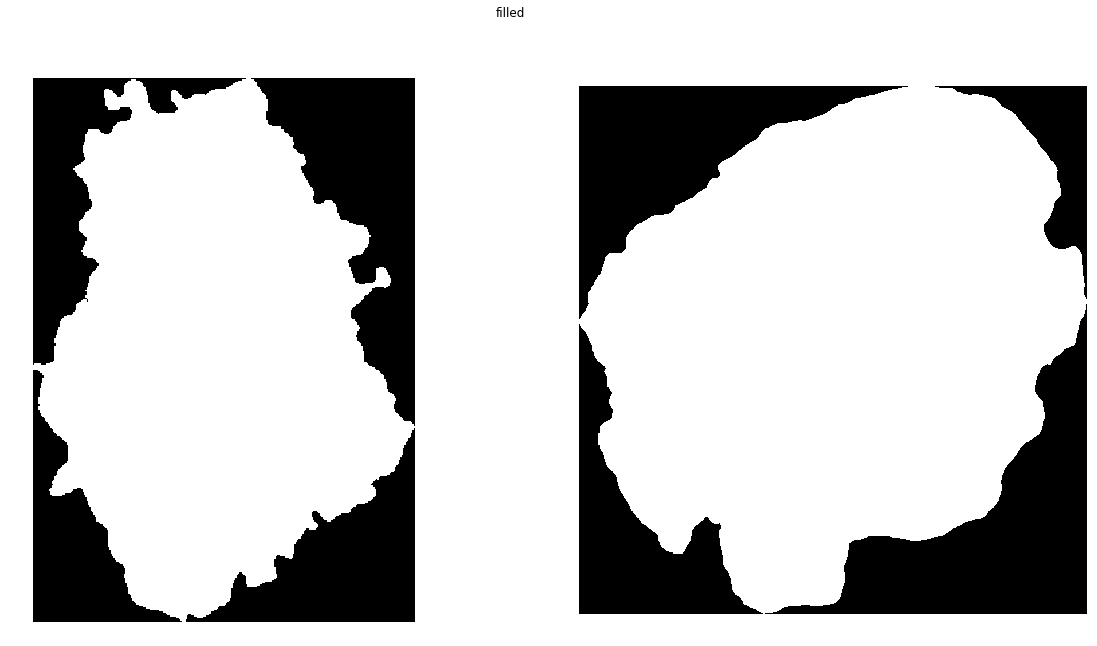

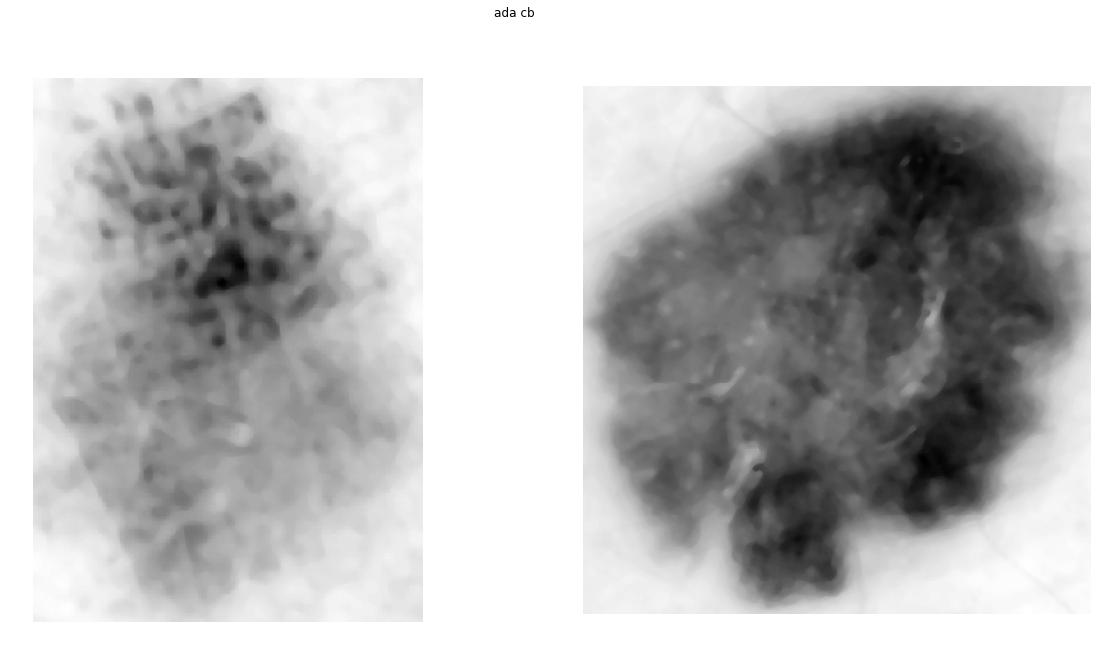

In [47]:
f, gambar1 = plt.subplots(1,2, figsize=(20, 10))
g, gambar2 = plt.subplots(1,2, figsize=(20, 10))
#h, gambar3 = plt.subplots(1,5, figsize=(20, 10))

gambar1 = gambar1.ravel()
gambar2 = gambar2.ravel()
#gambar3 = gambar3.ravel()

f.suptitle('filled')
g.suptitle('ada cb')
#h.suptitle('no cb')

for i, image1 in enumerate(filled[:]):
    gambar1[i].imshow(image1, cmap='gray')
    gambar1[i].axis('off')

for j, image2 in enumerate(cropped_images_pad[:]):
    gambar2[j].imshow(image2, cmap = 'gray')
    gambar2[j].axis('off')

#for k, image3 in enumerate(cropped_images_no[:]):
#    gambar3[k].imshow(image2, cmap = 'gray')
#    gambar3[k].axis('off')

# Segmentation

## Active Contour

In [49]:
hasil_contour = []
for i in tqdm(range(len(cropped_images_pad)), desc='contour'):
    init_ls = checkerboard_level_set(cropped_images_pad[i].shape, 10)
    ls = morphological_chan_vese(cropped_images_pad[i], 10, init_level_set=init_ls, smoothing=3)
    hasil_contour.append(ls)

contour: 100%|██████████| 2/2 [00:10<00:00,  5.02s/it]


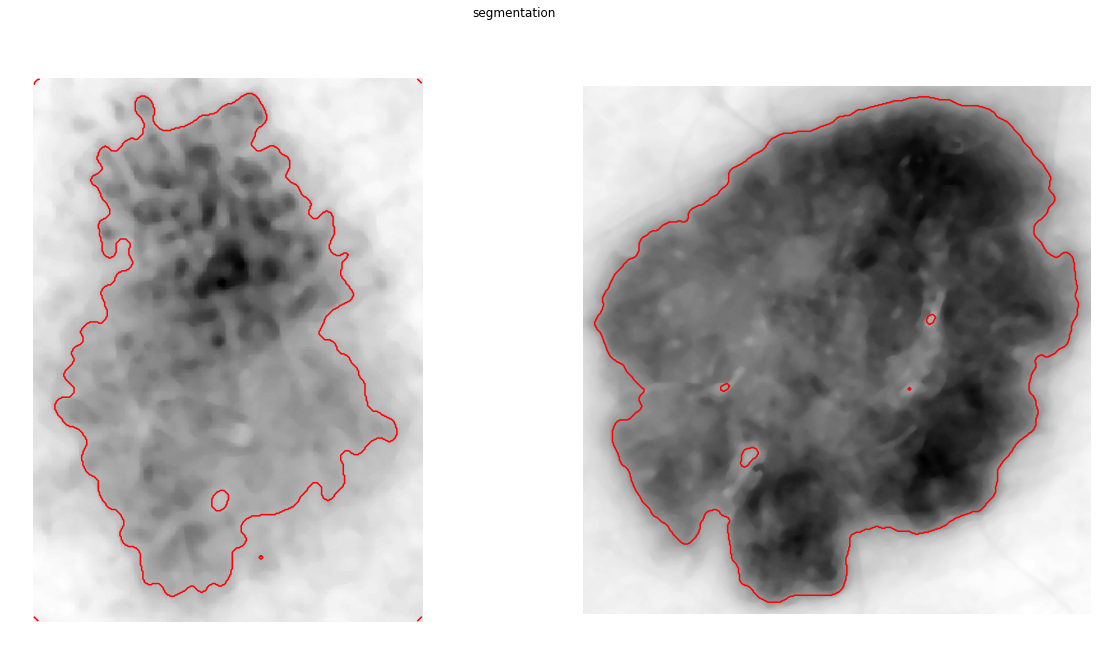

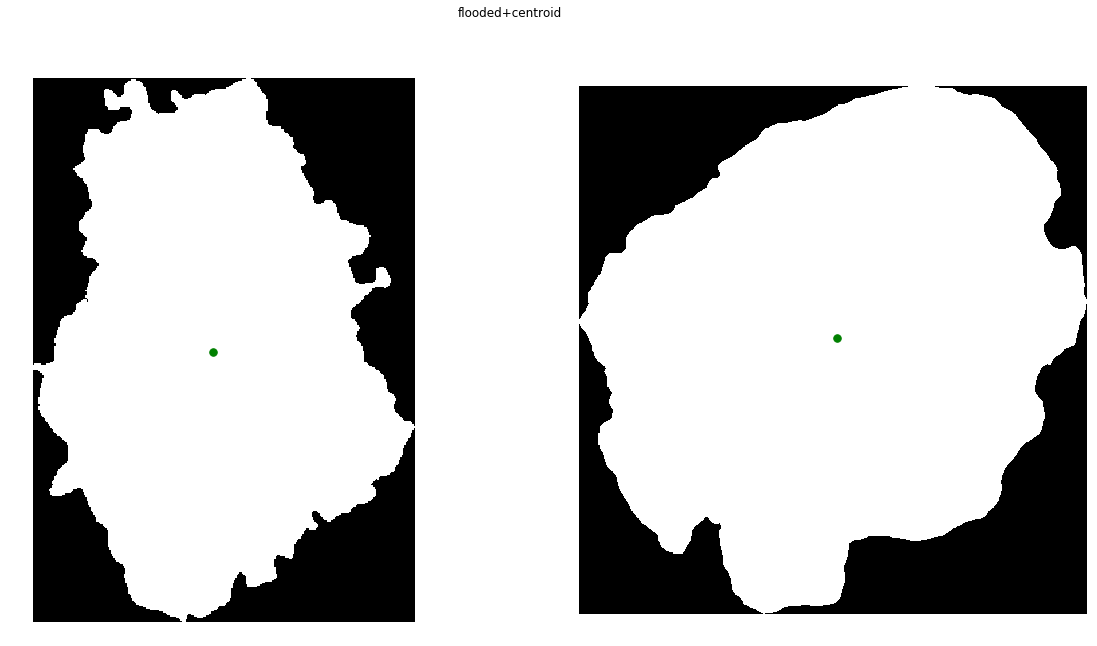

In [50]:
f, gambar1 = plt.subplots(1,2, figsize=(20, 10))
g, gambar2 = plt.subplots(1,2, figsize=(20, 10))
#h, gambar3 = plt.subplots(2,6, figsize=(20, 10))

gambar1 = gambar1.ravel()
gambar2 = gambar2.ravel()
#gambar3 = gambar3.ravel()

f.suptitle('segmentation')
#g.suptitle('binary')
g.suptitle('flooded+centroid')

for i, image1 in enumerate(cropped_images_pad[:]):
    gambar1[i].imshow(image1, cmap='gray')
    gambar1[i].contour(hasil_contour[i], [0.5], colors = 'r')
    gambar1[i].axis('off')

for g, image2 in enumerate(filled[:]):
    gambar2[g].imshow(image2, cmap='gray')
    gambar2[g].plot(x_center[g], y_center[g], '.g', markersize=15)
    gambar2[g].axis('off')

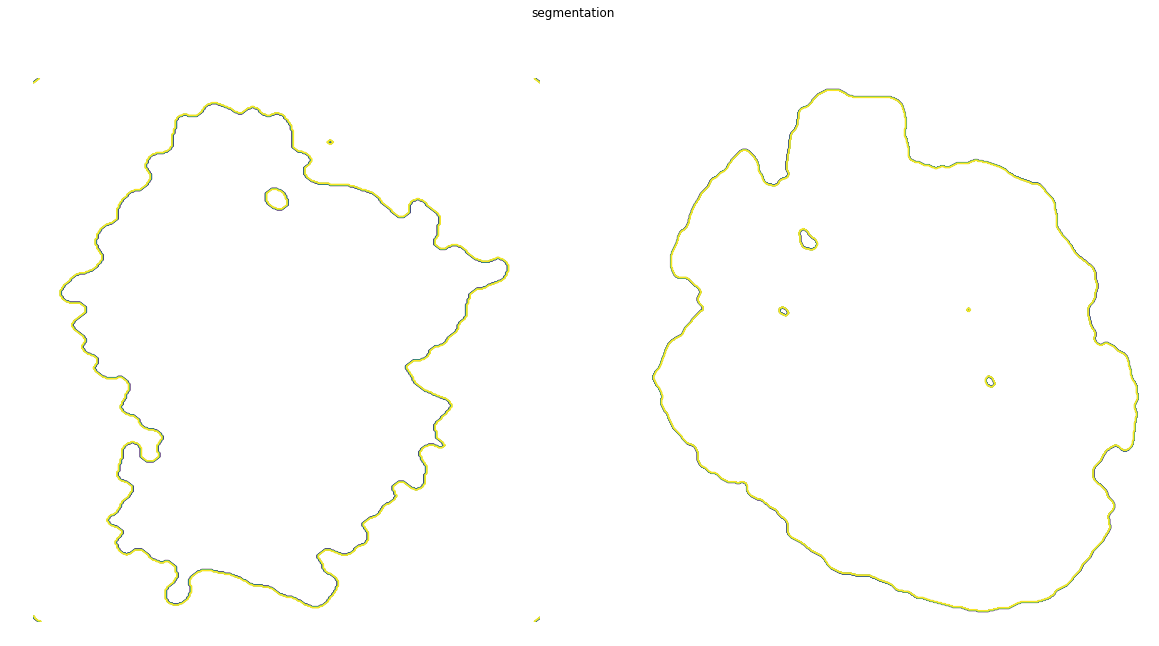

In [51]:
tepi_lesi = []
#for i in range(len(hasil_contour)):
    #tepi = plt.contour(hasil_contour[i])
    #tepi_lesi.append(tepi)

f, gambar1 = plt.subplots(1,2, figsize=(20, 10))

gambar1 = gambar1.ravel()

f.suptitle('segmentation')

for i, image1 in enumerate(hasil_contour[:]):
    gambar1[i].contour(hasil_contour[i], [0.5], colors = 'r')
    tepi = gambar1[i].contour(hasil_contour[i])
    gambar1[i].axis('off')        
    tepi_lesi.append(tepi)

## Sobel Filter

In [52]:
image_out = []

for i in tqdm(range(len(cropped_images)), desc = 'segmentasi'):
    imagecrop = cropped_images[i]*filled[i]
    image_out.append(imagecrop)

segmentasi: 100%|██████████| 2/2 [00:00<00:00, 4154.83it/s]


In [53]:
hasil_grad = []
hasil_lum = []
hasil_value = []

for i in range(len(image_out)):
    grad_mag = filters.sobel(image_out[i])
    lum = np.nonzero(grad_mag)
    lum = np.transpose(lum)
    value_lum = grad_mag[np.nonzero(grad_mag)]
    hasil_grad.append(grad_mag)
    hasil_lum.append(lum)
    hasil_value.append(value_lum)

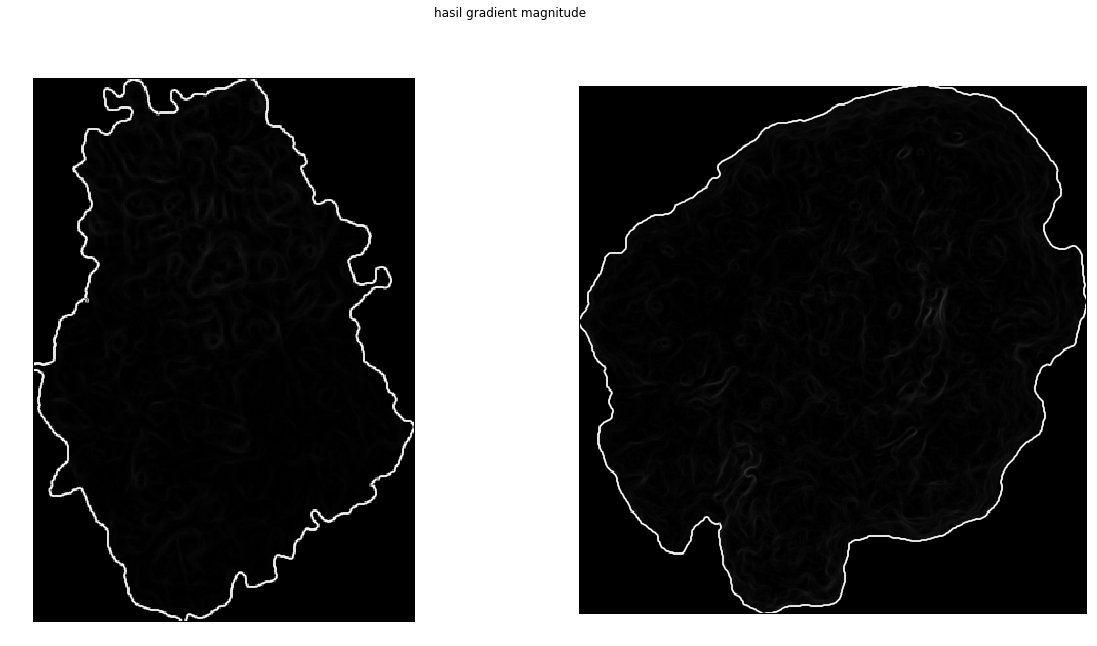

In [54]:
f, gambar1 = plt.subplots(1,2,figsize=(20, 10))

gambar1 = gambar1.ravel()

f.suptitle('hasil gradient magnitude')

for i, image1 in enumerate(hasil_grad[:]):
    gambar1[i].imshow(image1, cmap = 'gray')
    gambar1[i].axis('off')

# Feature Extraction

## Shape Feature

In [55]:
data_tepi = []

for i in range(len(tepi_lesi)):
    dat0 = tepi_lesi[i].allsegs[0]
    data_tepi.append(dat0)

In [56]:
jarak_all = []
jarak_kua_all = []

for i in range(len(data_tepi)):
    #jarak = []
    #jarak_kua = []
    nilaimax = len(data_tepi[i][0])
    
    for j in range(len(data_tepi[i])):
        nextvalue = len(data_tepi[i][j])
        if nextvalue >= nilaimax:
            nilaimax = nextvalue
            jarak = []
            jarak_kua = []
            for k in range(nilaimax):
                phy = (data_tepi[i][j][k][0]-x_center[i])**2 + (data_tepi[i][j][k][1]-y_center[i])**2
                d = np.sqrt(phy)
                dkua = d**2
                jarak.append(d) #kalo keprint hasil jarak yg data_tepi terakhir
                jarak_kua.append(dkua)
    jarak_all.append(jarak) #jarak_all ada 2 dimensi. jarak_all[i][j], i menandakan dia citra keberapa, 
                            #kalo j, jarak ke berapa dalam citra tsb
    jarak_kua_all.append(jarak_kua)

In [57]:
mean_jarak = []

for i in range(len(jarak_all)):
    mean_d = statistics.mean(jarak_all[i])
    mean_jarak.append(mean_d)

In [58]:
atas_all = []

for i in range(len(mean_jarak)):
    atas_new = []
    for j in range(len(jarak_all[i])):
        atas = (jarak_all[i][j]-mean_jarak[i])**2
        atas_new.append(atas)
    atas_all.append(atas_new)

In [59]:
edge_abrupt = []
mean_pigment = []
var_pigment = []

for i in range(len(atas_all)):
    cr = (1/perimeter[i]*sum(atas_all[i]))/(mean_jarak[i]**2)
    me = sum(jarak_all[i])/len(jarak_all[i])
    ve = ((sum(jarak_kua_all[i]))-me**2)/len(jarak_all[i])
    edge_abrupt.append(cr)
    mean_pigment.append(me)
    var_pigment.append(ve)

In [60]:
def fractal_dimension(Z, threshold):

    # Only for 2d image
    assert(len(Z.shape) == 2)
    def boxcount(Z, k):
        S = np.add.reduceat(
            np.add.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0),
                               np.arange(0, Z.shape[1], k), axis=1)

        # We count non-empty (0) and non-full boxes (k*k)
        return len(np.where((S > 0) & (S < k*k))[0])


    # Transform Z into a binary array
    Z = (Z < threshold)

    # Minimal dimension of image
    p = min(Z.shape)

    # Greatest power of 2 less than or equal to p
    n = 2**np.floor(np.log(p)/np.log(2))

    # Extract the exponent
    n = int(np.log(n)/np.log(2))

    # Build successive box sizes (from 2**n down to 2**1)
    sizes = 2**np.arange(n, 1, -1)

    # Actual box counting with decreasing size
    counts = []
    for size in sizes:
        counts.append(boxcount(Z, size))

    # Fit the successive log(sizes) with log (counts)
    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    return -coeffs[0]

In [61]:
fractal = []
for i in range(len(image_out)):
    fd = fractal_dimension(image_out[i], threshold = 0.2)
    fractal.append(fd)

## Color Feature

In [62]:
jarak_lum_all = []

for i in tqdm(range(len(hasil_lum)), desc='jarak'):
    jarak_lum = []
    for j in range(len(hasil_lum[i])):
        phyta_2 = (hasil_lum[i][j][1]-x_center[i])**2 + (hasil_lum[i][j][0]-y_center[i])**2
        d_lum = np.sqrt(phyta_2)
        jarak_lum.append(d_lum)
    jarak_lum_all.append(jarak_lum)

jarak: 100%|██████████| 2/2 [00:17<00:00,  8.83s/it]


In [63]:
mean_lum_all = []
mean_jarak_lum_all = []
varians_lum_all = []
varians_jarak_lum_all = []

for i in tqdm(range(len(jarak_lum_all)), desc='jarak'):
    mean_lum = statistics.mean(hasil_value[i])
    mean_jarak_lum = statistics.mean(jarak_lum_all[i])
    varians_lum = statistics.variance(hasil_value[i])
    varians_jarak_lum = statistics.variance(jarak_lum_all[i])
    
    mean_lum_all.append(mean_lum)
    mean_jarak_lum_all.append(mean_jarak_lum)
    varians_lum_all.append(varians_lum)
    varians_jarak_lum_all.append(varians_jarak_lum)

jarak: 100%|██████████| 2/2 [00:27<00:00, 13.97s/it]


In [64]:
hasil_nilai_atas_cpg = []
for i in tqdm(range(len(jarak_lum_all)), desc='cpg'):
    nilai_atas_cpg = []
    for j in range(len(jarak_lum_all[i])):
        atas_cpg = ((hasil_value[i][j]-mean_lum_all[i])*(jarak_lum_all[i][j]-mean_jarak_lum_all[i]))/(varians_lum_all[i]*varians_jarak_lum_all[i])
        nilai_atas_cpg.append(atas_cpg)
    hasil_nilai_atas_cpg.append(nilai_atas_cpg)

cpg: 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]


In [65]:
sum_cpg_new = []

for i in tqdm(range(len(hasil_nilai_atas_cpg)), desc='sumcpg'):
    sum_cpg = sum(hasil_nilai_atas_cpg[i])
    sum_cpg_new.append(sum_cpg)

sumcpg: 100%|██████████| 2/2 [00:00<00:00,  8.16it/s]


In [66]:
cpg_all = []

for i in tqdm(range(len(sum_cpg_new)), desc='cpgall'):
    cpg = 1/area_lesi[i]*sum_cpg_new[i]
    cpg_all.append(cpg)

cpgall: 100%|██████████| 2/2 [00:00<00:00, 199.39it/s]


In [30]:
image_out[0].dtype

dtype('uint8')

## Texture Feature

In [67]:
def GLCM(image) :
    bin_width = 32
    im = util.img_as_ubyte(image)
    im_binned = im//bin_width
    #gm = greycomatrix(im_binned,[1], [0, np.pi/4], levels=256//bin_width, symmetric=True, normed=True)
    gm = greycomatrix(image,[1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256, symmetric=True, normed=True)
    
    glcm_features = []
    
    energy = greycoprops(gm, 'energy')
    correlation = greycoprops(gm, 'correlation')
    homogeneity = greycoprops(gm, 'homogeneity')
    contrast = greycoprops(gm, 'contrast')
    
    glcm_features.extend(energy.tolist())
    glcm_features.extend(correlation.tolist())
    glcm_features.extend(homogeneity.tolist())
    glcm_features.extend(contrast.tolist())
    
    return glcm_features

In [68]:
nnn = []
n = max(compactness)

for i in range(len(compactness)):
    nn = compactness[i]/n
    nnn.append(nn)

In [69]:
borderr = []
for i in range(len(image_out)):
    border = (nnn[i]+edge_abrupt[i]+mean_pigment[i]+var_pigment[i]+fractal[i])/5
    borderr.append(border)

In [70]:
hasil = []

for i in tqdm(range(len(image_out)), desc = 'glcm'): 
    da = []
    
    de0 = GLCM(image_out[i])[0][0]
    de45 = GLCM(image_out[i])[0][1]
    de90 = GLCM(image_out[i])[0][2]
    de135 = GLCM(image_out[i])[0][3]
    dc0 = GLCM(image_out[i])[1][0]
    dc45 = GLCM(image_out[i])[1][1]
    dc90 = GLCM(image_out[i])[1][2]
    dc135 = GLCM(image_out[i])[1][3]
    dh0 = GLCM(image_out[i])[2][0]
    dh45 = GLCM(image_out[i])[2][1]
    dh90 = GLCM(image_out[i])[2][2]
    dh135 = GLCM(image_out[i])[2][3]
    dt0 = GLCM(image_out[i])[3][0]
    dt45 = GLCM(image_out[i])[3][1]
    dt90 = GLCM(image_out[i])[3][2]
    dt135 = GLCM(image_out[i])[3][3]
    nilai_a = asym_index[i]
    nilai_b = borderr[i]
    nilai_compact = nnn[i]
    nilai_edge = edge_abrupt[i]
    nilai_me = mean_pigment[i]
    nilai_var = var_pigment[i]
    nilai_frac = fractal[i]
    nilai_c = cpg_all[i]
    nilai_d = diameter[i]
    
    da.append(de0)
    da.append(dc0)
    da.append(dh0)
    da.append(dt0)
    
    da.append(de45)
    da.append(dc45)
    da.append(dh45)
    da.append(dt45)
    
    da.append(de90)
    da.append(dc90)
    da.append(dh90)
    da.append(dt90)
    
    da.append(de135)
    da.append(dc135)
    da.append(dh135)
    da.append(dt135)
    
    da.append(nilai_a)
    da.append(nilai_b)
    da.append(nilai_compact)
    da.append(nilai_edge)
    da.append(nilai_var)
    da.append(nilai_me)
    da.append(nilai_frac)
    da.append(nilai_c)
    da.append(nilai_d)
    
    hasil.append(da)

glcm: 100%|██████████| 2/2 [00:04<00:00,  2.41s/it]


# Into csv file

In [71]:
header = ['energy0', 'correlation0', 'homogeneity0', 'contrast0', 'energy45', 'correlation45', 'homogeneity45', 'contrast45', 'energy90', 'correlation90', 'homogeneity90', 'contrast90', 'energy135', 'correlation135', 'homogeneity135', 'contrast135', 'asym', 'border', 'compactness', 'edgeabrupt', 'var', 'mean', 'fractal','color', 'diameter']
df = pd.set_option('float_format', '{:f}'.format)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
df = pd.DataFrame(hasil, columns=header)
#df = pd.options.display.float_format = "{:.2f}".format

In [72]:
df

,energy0,correlation0,homogeneity0,contrast0,energy45,correlation45,homogeneity45,contrast45,energy90,correlation90,homogeneity90,contrast90,energy135,correlation135,homogeneity135,contrast135,asym,border,compactness,edgeabrupt,var,mean,fractal,color,diameter
0,0.358159,0.976089,0.771522,301.221987,0.354764,0.969626,0.720683,381.950461,0.359597,0.979171,0.779682,262.600182,0.354425,0.968183,0.718496,400.087950,0.000010,4359.588901,0.280730,0.053856,21652.724993,143.731628,1.153297,0.057795,306.572542
1,0.317623,0.981643,0.740269,87.938867,0.314622,0.972263,0.676704,132.647600,0.317861,0.982232,0.748239,85.123009,0.315175,0.976224,0.686532,113.707960,0.000009,11176.870024,1.000000,0.014040,55647.733461,234.511598,1.091019,0.067408,470.263440


In [ ]:
#tak command jaga2 kepencet
#df.to_csv('nomls2-9juni20.csv', index=False)

In [ ]:
#first = pd.read_csv('nomls1-9juni20.csv')
#second = pd.read_csv('nomls2-9juni20.csv')

#out = first.append(second)
#print(out)

#with open('nomls9juni20.csv', 'w', encoding='utf-8') as f:
#    out.to_csv(f, index=False)